ML Final Project

Spring 2017 - NYU CUSP

Notebook reads in datetime converted CitiBike Data by month (e.g. Jan_citi.csv) from 2016 and converts gets the counts and means per month

Written in Python 2.7 (Anaconda)

In [2]:
import numpy as np
import pandas as pd
import geopandas as gp
from geopandas import GeoDataFrame
import os
import io
import subprocess
from shapely.geometry import Point
from datetime import datetime
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score as rs
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import IsolationForest
from pandas.tseries.holiday import USFederalHolidayCalendar
from mpl_toolkits.mplot3d import Axes3D

from itertools import compress

np.random.seed(222)

%matplotlib inline
%pylab inline
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

Populating the interactive namespace from numpy and matplotlib


/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
`%matplotlib` prevents importing * from pylab and numpy


In [3]:
proj_folder = os.getcwd()

Check for spurious entires

## Remove spurious trip length rationale

From website: A $101 security deposit hold will be placed on your card when you purchase a pass. If you incur usage

fees, your card will be charged. The fee for a lost or stolen bike is $1200 (+ tax).


## Total Loss: 

Annual pass = 163/year + 101 Security fee + ($ 2.50 * min) = 5616 minutes
 
3 day Pass = 24 + 101 Security fee + ($ 2.50 * 15min) = 4031.25

Day Pass = 12 + 101 Security fee + ($4 * 15min) = 4076.25

Ride = 4 + 101 Security fee + ($4 * 15min) = 4106.25 

So remove anything longer than 5616 minutes, the maximum time before Total Loss and keep trip long than 1 minute

In [27]:
def citi_agg_stat_day(label):
    '''This function is supposed to: Further clean citi bike data, Group by day, 
    get daily count and mean and then export the files to prepare for a large merge'''
    #Import the csv
    getfile = "data/" + label + ".csv"
    citi_agg = pd.read_csv(getfile)
    #Drop column
    #citi_agg.drop('Unnamed: 0', axis=1, inplace=True)
    #change seconds to minutes
    citi_agg['tripduration'] = citi_agg['tripduration'].apply(lambda x: x / 60)
    #Remove spurious trips
    citi_agg = citi_agg[(citi_agg.tripduration > 1) & (citi_agg.tripduration < 5616)]
    #DatTime again??
    citi_agg['starttime'] = pd.to_datetime(citi_agg['starttime'])
    citi_agg['stoptime'] = pd.to_datetime(citi_agg['stoptime'])
    #Count Trips per day 
    citi_agg['bike_date'] = citi_agg['starttime'].dt.date
    citi_day_count = citi_agg.groupby(['bike_date'], as_index=False)['tripduration'].count()
    citi_day_count.columns = ['bike_date', 'bike_trip_count']
    
    #take the mean of the taxi stats each day
    citi_stat_agg = citi_agg.groupby(['bike_date'], as_index=False).mean()
    
    #Merge the seperate DataFrames 
    citi_df_by_day = citi_stat_agg.merge(citi_day_count, on='bike_date')
    
    #Get the weekday
    citi_df_by_day['weekday'] = 0
    for i in range(len(citi_df_by_day)):
        citi_df_by_day['weekday'].iloc[i] = citi_df_by_day.bike_date.iloc[i].weekday()
        
    #Export to csv
    output = "data/" + label + "_df_by_day.csv"
    citi_df_by_day.to_csv(output)
    #citi_df_byday_all
    return citi_df_by_day 

In [57]:
def citi_daystation_count(label):
    '''This function is supposed to: Further clean citi bike data, do some grouping
    and calculations and then export the files to prepare for a large merge'''
    #Import the csv
    getfile1 = "data/" + label + ".csv"
    citi_agg1 = pd.read_csv(getfile1)
    #Drop column
    #citi_agg1.drop('Unnamed: 0', axis=1, inplace=True)
    #change seconds to minutes
    citi_agg1['tripduration'] = citi_agg1['tripduration'].apply(lambda x: x / 60)
    #Remove spurious trips
    citi_agg1 = citi_agg1[(citi_agg1.tripduration > 1) & (citi_agg1.tripduration < 5616)]
    #DatTime again??
    citi_agg1['starttime'] = pd.to_datetime(citi_agg1['starttime'])
    citi_agg1['stoptime'] = pd.to_datetime(citi_agg1['stoptime'])
    #citi_agg['day_number'] = label.starttime.apply(lambda x: x.hour)
    citi_agg1['bike_date'] = citi_agg1['starttime'].dt.date
    
    
    #Count Trips per day 
    citi_agg1['bike_date'] = citi_agg1['starttime'].dt.date
    citi_day_count1 = citi_agg1.groupby(['bike_date', "start station id"], as_index=False)['tripduration'].count()
    citi_day_count1.columns = ['bike_date', "start station id",'bike_trip_count']
    return citi_day_count1 

## Aggregate by day and Export

In [16]:
columns =['bike_date', 'tripduration', 'start station id', 'start station latitude', 'start station longitude', \
          'end station id', 'end station latitude','end station longitude', 'bikeid', 'birth year', \
          'gender', 'start_hour', 'end_hour','bike_trip_count']

In [47]:
months = ["Jan_citi", "Feb_citi", "Mar_citi", "Apr_citi", "May_citi", "Jun_citi", "Jul_citi", "Aug_citi", \
          "Sep_citi", "Oct_citi", "Nov_citi", "Dec_citi"]

In [19]:
months2 = ["citibike_201501", "citibike_201502", "citibike_201503", "citibike_201504", "citibike_201505", \
          "citibike_201506", "citibike_201507", "citibike_201508", "citibike_201509", "citibike_201510", \
          "citibike_201511", "citibike_201512"]

In [17]:
# Create Empty dataframe
#citi_df_all_day = pd.read_csv(io.StringIO(None), names=columns, dtype=dict(zip(columns,[object, float, float, float, float, float, float, float, float, float, float, float, float, int, int])))

citi_df_all_day = pd.DataFrame(columns=columns)
citi_df_all_day.head()

,bike_date,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,start_hour,end_hour,bike_trip_count,weekday


In [50]:
# Create the files in bulk
# By day with count and mean
#for i in (months2):
#    x = citi_agg_stat_day(str(i))
#    citi_df_all_day = citi_df_all_day.append(x, ignore_index = True)
        

In [20]:
for i in (months2):
    print i
    df = pd.read_csv('data/' + i + '.csv')
    
    #change seconds to minutes
    df['tripduration'] = df['tripduration'].apply(lambda x: x / 60)
    #Remove spurious trips
    df = df[(df.tripduration > 1) & (df.tripduration < 5616)]
    #DatTime again??
    df['starttime'] = pd.to_datetime(df['starttime'])
    df['stoptime'] = pd.to_datetime(df['stoptime'])
    #citi_agg['day_number'] = label.starttime.apply(lambda x: x.hour)
    df['bike_date'] = df['starttime'].dt.date
    
    
    #Count Trips per day 
    
    citi_df_all_day = citi_df_all_day.append(df, ignore_index = True)

citibike_201501
citibike_201502
citibike_201503
citibike_201504
citibike_201505
citibike_201506
citibike_201507
citibike_201508
citibike_201509
citibike_201510
citibike_201511
citibike_201512


In [21]:
citi_df_all_day.to_csv('data/citi_df_all_day.csv')

In [22]:
#citi_df_all_day.head()

In [23]:
#citi_df_all_day = pd.read_csv('data/citi_df_all_day.csv')

In [48]:
citi_df_all_day.head()

,bike_date,bike_trip_count,bikeid,birth year,end station id,end station latitude,end station longitude,end station name,end_hour,gender,start station id,start station latitude,start station longitude,start station name,start_hour,starttime,stoptime,tripduration,usertype,weekday
0,2015-01-01,NaN,18660.0,1960.0,265.0,40.722293,-73.991475,Stanton St & Chrystie St,NaN,2.0,455.0,40.750020,-73.969053,1 Ave & E 44 St,NaN,2015-01-01 00:01:00,2015-01-01 00:24:00,22.0,Subscriber,NaN
1,2015-01-01,NaN,16085.0,1963.0,482.0,40.739355,-73.999318,W 15 St & 7 Ave,NaN,1.0,434.0,40.743174,-74.003664,9 Ave & W 18 St,NaN,2015-01-01 00:02:00,2015-01-01 00:08:00,6.0,Subscriber,NaN
2,2015-01-01,NaN,20845.0,1974.0,505.0,40.749013,-73.988484,6 Ave & W 33 St,NaN,1.0,491.0,40.740964,-73.986022,E 24 St & Park Ave S,NaN,2015-01-01 00:04:00,2015-01-01 00:10:00,5.0,Subscriber,NaN
3,2015-01-01,NaN,19610.0,1969.0,399.0,40.688515,-73.964763,Lafayette Ave & St James Pl,NaN,1.0,384.0,40.683178,-73.965964,Fulton St & Waverly Ave,NaN,2015-01-01 00:04:00,2015-01-01 00:07:00,3.0,Subscriber,NaN
4,2015-01-01,NaN,20197.0,1977.0,432.0,40.726218,-73.983799,E 7 St & Avenue A,NaN,1.0,474.0,40.745168,-73.986831,5 Ave & E 29 St,NaN,2015-01-01 00:05:00,2015-01-01 00:21:00,16.0,Subscriber,NaN


### Add holiday / day of week / weekend features

In [49]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016', return_name=True)
holidays.name = 'name'
holidays.head()

2012-01-02                 New Years Day
2012-01-16    Dr. Martin Luther King Jr.
2012-02-20                Presidents Day
2012-05-28                   MemorialDay
2012-07-04                      July 4th
Name: name, dtype: object

In [50]:
holidays_all = pd.concat([holidays,
                         "Day Before " + holidays.shift(-1, 'D'),
                         "Day After " + holidays.shift(1, 'D')])
holidays_all = holidays_all.sort_index()

In [51]:
citi_df_all_day['bike_date'] = pd.to_datetime(citi_df_all_day['bike_date'])

In [52]:
#add holiday dummy variable
citi_df_all_day['holiday'] = 0
citi_df_all_day['holiday'][citi_df_all_day['bike_date'].isin(holidays_all.index.date)] = 1

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [53]:
citi_df_all_day['day_of_week'] = citi_df_all_day.bike_date.apply(lambda x: x.weekday())

In [54]:
#control for Friday / Saturday nights
citi_df_all_day['weekend'] = 0
citi_df_all_day['weekend'][(citi_df_all_day['day_of_week'] == 4) | (citi_df_all_day['day_of_week'] == 5)] = 1

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


## Grouping by station and day

In [55]:
citi_df_all_day_mean = citi_df_all_day.groupby(['bike_date', 'holiday', 'weekend', 'start station id', 'start station latitude', 'start station longitude'], as_index=False)['tripduration'].mean()
citi_df_all_day_mean.head()

,bike_date,holiday,weekend,start station id,start station latitude,start station longitude,tripduration
0,2015-01-01,1,0,72.0,40.767272,-73.993929,17.100000
1,2015-01-01,1,0,79.0,40.719116,-74.006667,14.133333
2,2015-01-01,1,0,82.0,40.711174,-74.000165,9.333333
3,2015-01-01,1,0,83.0,40.683826,-73.976323,7.428571
4,2015-01-01,1,0,116.0,40.741776,-74.001497,13.307692


In [56]:
citi_df_all_day_count = citi_df_all_day.groupby(['bike_date', 'holiday', 'weekend', 'start station id', 'start station latitude', 'start station longitude'], as_index=False)['bikeid'].count()
citi_df_all_day_count.head()

,bike_date,holiday,weekend,start station id,start station latitude,start station longitude,bikeid
0,2015-01-01,1,0,72.0,40.767272,-73.993929,10
1,2015-01-01,1,0,79.0,40.719116,-74.006667,15
2,2015-01-01,1,0,82.0,40.711174,-74.000165,9
3,2015-01-01,1,0,83.0,40.683826,-73.976323,7
4,2015-01-01,1,0,116.0,40.741776,-74.001497,26


In [57]:
citi_df_all_day_agg = citi_df_all_day_count.merge(citi_df_all_day_mean)
citi_df_all_day_agg.head()

,bike_date,holiday,weekend,start station id,start station latitude,start station longitude,bikeid,tripduration
0,2015-01-01,1,0,72.0,40.767272,-73.993929,10,17.100000
1,2015-01-01,1,0,79.0,40.719116,-74.006667,15,14.133333
2,2015-01-01,1,0,82.0,40.711174,-74.000165,9,9.333333
3,2015-01-01,1,0,83.0,40.683826,-73.976323,7,7.428571
4,2015-01-01,1,0,116.0,40.741776,-74.001497,26,13.307692


In [66]:
citi_df_all_day_agg.columns = ['bike_date', 'holiday', 'weekend', 'start_station_id', 'start station latitude',\
                              'start station longitude', 'bike_trip_count', 'tripduration']
citi_df_all_day_agg.head()

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration
0,2015-01-01,1,0,72.0,40.767272,-73.993929,10,17.100000
1,2015-01-01,1,0,79.0,40.719116,-74.006667,15,14.133333
2,2015-01-01,1,0,82.0,40.711174,-74.000165,9,9.333333
3,2015-01-01,1,0,83.0,40.683826,-73.976323,7,7.428571
4,2015-01-01,1,0,116.0,40.741776,-74.001497,26,13.307692


## Grouping by day

In [60]:
citi_df_day_mean = citi_df_all_day.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['tripduration'].mean()
citi_df_day_mean.head()

,bike_date,holiday,weekend,tripduration
0,2015-01-01,1,0,13.061735
1,2015-01-02,1,1,11.813467
2,2015-01-03,0,1,10.559855
3,2015-01-04,0,0,10.936526
4,2015-01-05,0,0,10.245255


In [62]:
citi_df_day_count = citi_df_all_day.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['bikeid'].count()
citi_df_day_count.head()

,bike_date,holiday,weekend,bikeid
0,2015-01-01,1,0,5232
1,2015-01-02,1,1,11183
2,2015-01-03,0,1,4419
3,2015-01-04,0,0,7767
4,2015-01-05,0,0,14332


In [64]:
citi_df_day_agg = citi_df_day_count.merge(citi_df_day_mean)
citi_df_day_agg.head()

,bike_date,holiday,weekend,bikeid,tripduration
0,2015-01-01,1,0,5232,13.061735
1,2015-01-02,1,1,11183,11.813467
2,2015-01-03,0,1,4419,10.559855
3,2015-01-04,0,0,7767,10.936526
4,2015-01-05,0,0,14332,10.245255


In [65]:
citi_df_day_agg.columns = ['bike_date', 'holiday', 'weekend', 'bike_trip_count', 'tripduration']
citi_df_day_agg.head()

,bike_date,holiday,weekend,bike_trip_count,tripduration
0,2015-01-01,1,0,5232,13.061735
1,2015-01-02,1,1,11183,11.813467
2,2015-01-03,0,1,4419,10.559855
3,2015-01-04,0,0,7767,10.936526
4,2015-01-05,0,0,14332,10.245255


## Clustering Anomaly Detection

### K-means Anomaly Detection

In [46]:
cluster_features = ['bike_trip_count', 'tripduration', 'holiday', 'weekend']

In [67]:
X = citi_df_day_agg[cluster_features]
X.head(2)

,bike_trip_count,tripduration,holiday,weekend
0,5232,13.061735,1,0
1,11183,11.813467,1,1


In [68]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()
    
X.head()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,bike_trip_count,tripduration,holiday,weekend
0,-1.626679,-0.460979,3.337076,-0.630377
1,-1.180955,-0.867642,3.337076,1.582005
2,-1.687572,-1.276046,-0.298843,1.582005
3,-1.436810,-1.153334,-0.298843,-0.630377
4,-0.945098,-1.378537,-0.298843,-0.630377


In [69]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.333670988682
For n_clusters =3, the average silhouette_score is :0.391073718408
For n_clusters =4, the average silhouette_score is :0.475596725822
For n_clusters =5, the average silhouette_score is :0.512486044108
For n_clusters =6, the average silhouette_score is :0.525734360304
For n_clusters =7, the average silhouette_score is :0.530004287399
For n_clusters =8, the average silhouette_score is :0.536582976357


In [70]:
n=5
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [71]:
citi_df_day_agg['cluster'] = res.cluster
citi_df_day_agg['km_score'] = res.score
citi_df_day_agg['outlier'] = 0
citi_df_day_agg.sort_values("km_score",ascending=False, inplace=True)

In [87]:
citi_df_day_agg.head(10)

,bike_date,holiday,weekend,bike_trip_count,tripduration,cluster,km_score,outlier,color
358,2015-12-25,1,1,12188,30.319905,0,5.019717,1,red
45,2015-02-15,1,0,2542,9.134540,0,2.784692,1,red
46,2015-02-16,1,0,3930,9.587277,0,2.606726,1,red
220,2015-08-09,0,0,32395,22.888563,4,2.508555,1,red
1,2015-01-02,1,1,11183,11.813467,0,2.429584,1,red
283,2015-10-11,1,0,38592,22.411018,0,2.394888,1,red
184,2015-07-04,1,1,21503,20.964610,0,2.374043,1,red
47,2015-02-17,1,0,4746,10.410029,0,2.356606,1,red
329,2015-11-26,1,0,13106,22.674729,0,2.305605,1,red
359,2015-12-26,1,1,13709,19.987818,0,2.283828,1,red


In [73]:
citi_df_day_agg['outlier'][:10] = 1 

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [82]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    elif (Data1.cluster == 2):
        return "purple"
    elif (Data1.cluster == 3):
        return "yellow"
    else:
        return "green"

citi_df_day_agg = citi_df_day_agg.assign(color=citi_df_day_agg.apply(set_color, axis=1))

In [83]:
citi_df_day_agg_w_z_scores = citi_df_day_agg.merge(X, left_index=True, right_index=True)

In [84]:
citi_df_day_agg_w_z_scores.sort_values("km_score",ascending=False, inplace=True)
citi_df_day_agg_w_z_scores[['bike_date', 'km_score',  'bike_trip_count_x',\
                          'tripduration_x', 'holiday_x', 'weekend_x', \
                                    'bike_trip_count_y', 'tripduration_y', 'holiday_y', 'weekend_y']].head(15)

,bike_date,km_score,bike_trip_count_x,tripduration_x,holiday_x,weekend_x,bike_trip_count_y,tripduration_y,holiday_y,weekend_y
358,2015-12-25,5.019717,12188,30.319905,1,1,-1.105681,5.161421,3.337076,1.582005
45,2015-02-15,2.784692,2542,9.134540,1,0,-1.828157,-1.740388,3.337076,-0.630377
46,2015-02-16,2.606726,3930,9.587277,1,0,-1.724198,-1.592895,3.337076,-0.630377
220,2015-08-09,2.508555,32395,22.888563,0,0,0.407804,2.740424,-0.298843,-0.630377
1,2015-01-02,2.429584,11183,11.813467,1,1,-1.180955,-0.867642,3.337076,1.582005
283,2015-10-11,2.394888,38592,22.411018,1,0,0.871953,2.584848,3.337076,-0.630377
184,2015-07-04,2.374043,21503,20.964610,1,1,-0.407996,2.113635,3.337076,1.582005
47,2015-02-17,2.356606,4746,10.410029,1,0,-1.663080,-1.324857,3.337076,-0.630377
329,2015-11-26,2.305605,13106,22.674729,1,0,-1.036924,2.670761,3.337076,-0.630377
359,2015-12-26,2.283828,13709,19.987818,1,1,-0.991760,1.795414,3.337076,1.582005


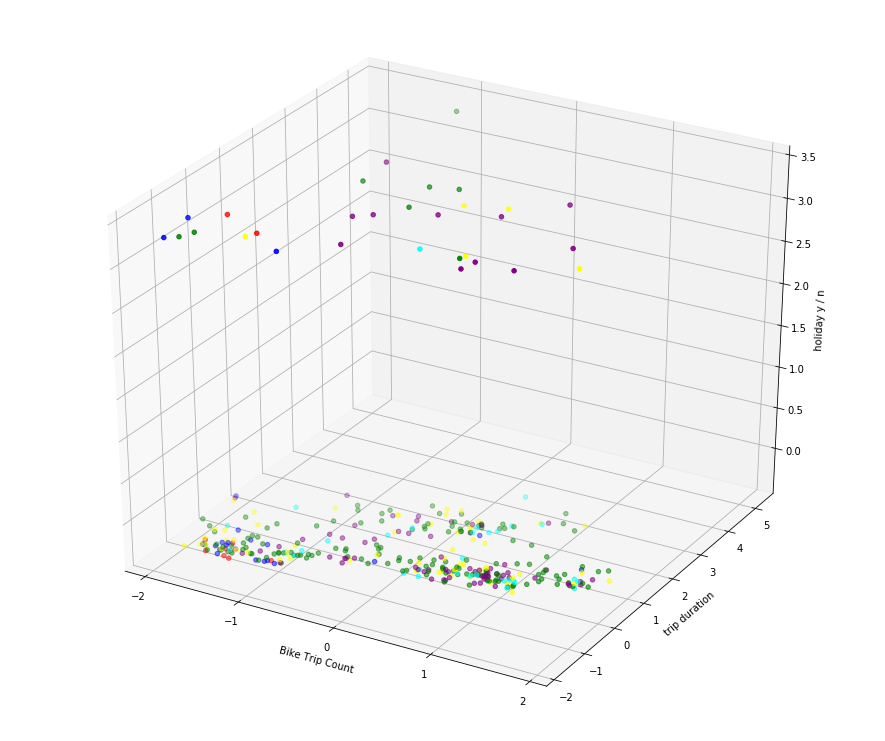

In [88]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.bike_trip_count, X.tripduration, X.holiday, c=citi_df_day_agg.color)
ax.set_xlabel('Bike Trip Count')
ax.set_ylabel('trip duration')
ax.set_zlabel('holiday y / n')
# set x ticks and labels
ax.set_xticks(range(-2, 3, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Isolation Anomaly Detection

### Isolation Forest Anomaly Detection

In [90]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [91]:
citi_df_day_agg_w_z_scores['decision_function'] = clf.decision_function(X)

In [92]:
citi_df_day_agg_w_z_scores.sort_values(by='decision_function').head(10)

,bike_date,holiday_x,weekend_x,bike_trip_count_x,tripduration_x,cluster,km_score,outlier,color,bike_trip_count_y,tripduration_y,holiday_y,weekend_y,decision_function
186,2015-07-06,0,0,34914,14.691843,4,0.184712,0,green,0.596475,0.070081,-0.298843,-0.630377,-0.168293
179,2015-06-29,0,0,37698,14.889570,4,0.183740,0,green,0.804994,0.134496,-0.298843,-0.630377,-0.154082
321,2015-11-18,0,0,41050,13.416370,4,0.711714,0,green,1.056055,-0.345445,-0.298843,-0.630377,-0.152170
82,2015-03-24,0,0,15999,10.938746,2,0.342785,0,purple,-0.820241,-1.152611,-0.298843,-0.630377,-0.142506
40,2015-02-10,0,0,10246,10.221745,2,0.484570,0,purple,-1.251135,-1.386197,-0.298843,-0.630377,-0.138729
314,2015-11-11,1,0,37303,14.037584,0,1.335947,0,blue,0.775409,-0.143065,3.337076,-0.630377,-0.133882
266,2015-09-24,0,0,52177,16.750043,4,1.327960,0,green,1.889457,0.740605,-0.298843,-0.630377,-0.125840
349,2015-12-16,0,0,35214,12.566110,4,0.867658,0,green,0.618944,-0.622445,-0.298843,-0.630377,-0.125427
45,2015-02-15,1,0,2542,9.134540,0,2.784692,1,red,-1.828157,-1.740388,3.337076,-0.630377,-0.123867
131,2015-05-12,0,0,34945,14.210617,4,0.336242,0,green,0.598797,-0.086694,-0.298843,-0.630377,-0.122899


In [94]:
citi_df_day_agg_w_z_scores_final = citi_df_day_agg_w_z_scores[['bike_date', 'km_score', 'decision_function', 'bike_trip_count_x',\
                          'tripduration_x', 'holiday_x', 'weekend_x', \
                                    'bike_trip_count_y', 'tripduration_y', 'holiday_y', 'weekend_y']]
citi_df_day_agg_w_z_scores_final.head()

,bike_date,km_score,decision_function,bike_trip_count_x,tripduration_x,holiday_x,weekend_x,bike_trip_count_y,tripduration_y,holiday_y,weekend_y
358,2015-12-25,5.019717,-0.096909,12188,30.319905,1,1,-1.105681,5.161421,3.337076,1.582005
45,2015-02-15,2.784692,-0.123867,2542,9.134540,1,0,-1.828157,-1.740388,3.337076,-0.630377
46,2015-02-16,2.606726,-0.023027,3930,9.587277,1,0,-1.724198,-1.592895,3.337076,-0.630377
220,2015-08-09,2.508555,0.061464,32395,22.888563,0,0,0.407804,2.740424,-0.298843,-0.630377
1,2015-01-02,2.429584,0.060639,11183,11.813467,1,1,-1.180955,-0.867642,3.337076,1.582005


In [95]:
citi_df_day_agg_w_z_scores_final.to_csv('citi_clustered_by_day_w_z_scores.csv')

## Look at specific areas and see what times / dates around there are anomalies
### Madison Square Gardens (40.750556, -73.993611)

In [96]:
latlon_list = [40.750556, -73.993611]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
citi_df_total_subset = citi_df_all_day_agg[(citi_df_all_day_agg['start station latitude'] > (latlon_list[0] - 0.005)) & (citi_df_all_day_agg['start station latitude'] < (latlon_list[0] + 0.005))]
citi_df_total_subset = citi_df_total_subset[(citi_df_total_subset['start station longitude'] > (latlon_list[1] - 0.005)) & (citi_df_total_subset['start station longitude'] < (latlon_list[1] + 0.005))]

In [97]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(citi_df_total_subset['start station longitude'], citi_df_total_subset['start station latitude'])]

In [98]:
crs = {'init': 'epsg:4326'}
citi_df_total_subset = GeoDataFrame(citi_df_total_subset, crs=crs, geometry=geometry)

In [99]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [100]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

,geometry
0,"POLYGON ((-73.98861100000001 40.750556, -73.98..."


In [101]:
# only keep points within MSG buffer
citi_df_total_subset = citi_df_total_subset[citi_df_total_subset.geometry.intersects(MSG_gp.geometry[0])]

In [102]:
#take the mean of the taxi stats each day / hour
citi_df_MSG_mean = citi_df_total_subset.groupby(['bike_date'], as_index=False).mean()
citi_df_MSG_mean.head()

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration
0,2015-01-01,1.0,0.0,481.625,40.750011,-73.994025,22.500,13.264523
1,2015-01-02,1.0,1.0,481.625,40.750011,-73.994025,66.125,10.106404
2,2015-01-03,0.0,1.0,481.625,40.750011,-73.994025,19.625,9.091219
3,2015-01-04,0.0,0.0,481.625,40.750011,-73.994025,34.125,9.358956
4,2015-01-05,0.0,0.0,481.625,40.750011,-73.994025,136.125,9.178132


In [103]:
citi_df_MSG_mean['day_of_week'] = citi_df_MSG_mean.bike_date.apply(lambda x: x.weekday())

In [104]:
# read in NYC street shapefile
'''
shapefile taken from https://geo.nyu.edu/catalog/nyu_2451_34565

'''
ny_streets_raw = gp.read_file(proj_folder + '/data/nyu_2451_34565/nyu_2451_34565.shp')
ny_streets_raw = ny_streets_raw.to_crs(epsg=4326)
# only keep points within MSG buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

In [107]:
citi_df_total_subset

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration,geometry
158,2015-01-01,1,0,379.0,40.749156,-73.991600,15,16.266667,POINT (-73.99160000000001 40.749156)
216,2015-01-01,1,0,442.0,40.746647,-73.993915,19,12.368421,POINT (-73.993915 40.746647)
262,2015-01-01,1,0,490.0,40.751551,-73.993934,27,12.592593,POINT (-73.993934 40.751551)
264,2015-01-01,1,0,492.0,40.750200,-73.990931,19,9.000000,POINT (-73.99093085 40.75019995)
266,2015-01-01,1,0,494.0,40.747348,-73.997236,19,6.947368,POINT (-73.99723551 40.74734825)
283,2015-01-01,1,0,512.0,40.750073,-73.998393,19,10.052632,POINT (-73.99839279 40.7500727)
292,2015-01-01,1,0,521.0,40.750450,-73.994811,41,12.317073,POINT (-73.99481050999999 40.75044999)
294,2015-01-01,1,0,523.0,40.754666,-73.991382,21,26.571429,POINT (-73.99138152 40.75466591)
485,2015-01-02,1,1,379.0,40.749156,-73.991600,65,8.553846,POINT (-73.99160000000001 40.749156)
542,2015-01-02,1,1,442.0,40.746647,-73.993915,71,10.901408,POINT (-73.993915 40.746647)


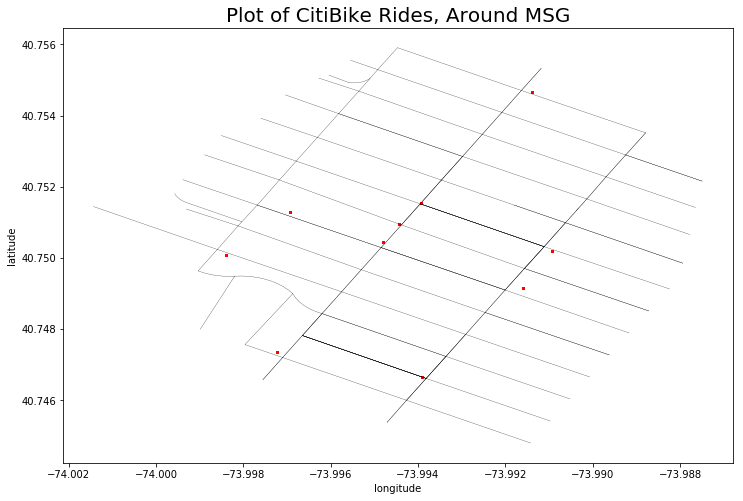

In [109]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = citi_df_total_subset.sample(n=1000)
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of CitiBike Stations, Around MSG", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## MSG anomaly analysis (isolation forest)

In [ ]:
citi_df_total_subset_by_day = citi_df_total_subset.groupby(['bike_date', 'holiday', 'weekend', ''])

In [111]:
X = citi_df_total_subset[cluster_features]
X.head(2)

,bike_trip_count,tripduration,holiday,weekend
158,15,16.266667,1,0
216,19,12.368421,1,0


In [112]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [113]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [114]:
citi_df_total_subset['decision_function'] = clf.decision_function(X)

In [115]:
citi_df_total_subset.sort_values(by='decision_function').head(10)

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration,geometry,decision_function
131123,2015-12-25,1,1,379.0,40.749156,-73.991600,30,48.866667,POINT (-73.99160000000001 40.749156),-0.192207
131626,2015-12-26,1,1,442.0,40.746647,-73.993915,44,41.340909,POINT (-73.993915 40.746647),-0.189352
131223,2015-12-25,1,1,492.0,40.750200,-73.990931,42,32.309524,POINT (-73.99093085 40.75019995),-0.184808
131221,2015-12-25,1,1,490.0,40.751551,-73.993934,47,32.744681,POINT (-73.993934 40.751551),-0.183112
131253,2015-12-25,1,1,523.0,40.754666,-73.991382,28,22.500000,POINT (-73.99138152 40.75466591),-0.163630
131673,2015-12-26,1,1,492.0,40.750200,-73.990931,66,21.681818,POINT (-73.99093085 40.75019995),-0.147823
131242,2015-12-25,1,1,512.0,40.750073,-73.998393,29,18.379310,POINT (-73.99839279 40.7500727),-0.144363
117763,2015-11-26,1,0,442.0,40.746647,-73.993915,50,44.920000,POINT (-73.993915 40.746647),-0.142236
58582,2015-07-02,1,0,521.0,40.750967,-73.994442,562,14.530249,POINT (-73.99444207549095 40.75096734871597),-0.140226
46703,2015-05-26,1,0,521.0,40.750967,-73.994442,668,12.797904,POINT (-73.99444207549095 40.75096734871597),-0.139467


### K-Means Cluster Model Anomaly Detection

In [116]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.453352380411
For n_clusters =3, the average silhouette_score is :0.53402779433
For n_clusters =4, the average silhouette_score is :0.539953686521
For n_clusters =5, the average silhouette_score is :0.581270544201
For n_clusters =6, the average silhouette_score is :0.494508518538
For n_clusters =7, the average silhouette_score is :0.521420996732
For n_clusters =8, the average silhouette_score is :0.478009808827


In [117]:
n=5
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [118]:
citi_df_total_subset['cluster'] = res.cluster
citi_df_total_subset['km_score'] = res.score
citi_df_total_subset['outlier'] = 0
citi_df_total_subset.sort_values("km_score",ascending=False, inplace=True)

In [119]:
citi_df_total_subset['outlier'][:10] = 1 

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [134]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    elif (Data1.cluster == 2):
        return "pink"
    elif (Data1.cluster == 3):
        return "yellow"
    else:
        return "green"

citi_df_total_subset = citi_df_total_subset.assign(color=citi_df_total_subset.apply(set_color, axis=1))

In [155]:
X.sort_values("tripduration",ascending=False, inplace=True)

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


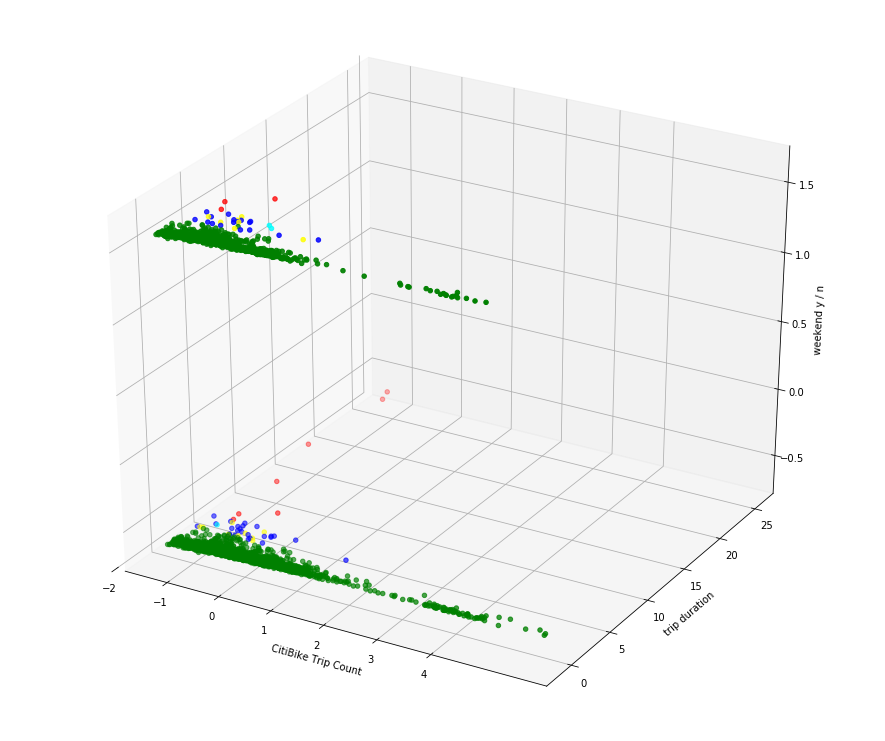

In [156]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.bike_trip_count, X.tripduration, X.weekend, c=citi_df_total_subset.color)
ax.set_xlabel('CitiBike Trip Count')
ax.set_ylabel('trip duration')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-2, 5, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()